In [7]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

N=130       # Numero de cidades

rng = np.random.default_rng(seed=42)   # Define as posições aleatórias das cidades
x=rng.random(N)
y=rng.random(N)

# define o caminho que liga as cidades (inicialmente a sequencia como foi criada)
path_ini = np.zeros(N,dtype=np.int16)
for i in range(N):
    path_ini[i]=i

2) Rodar o algoritmo de metropolis
3) Acompanhem a evolução da distância (energia) no decorrer do processo e veja se está de acordo com o que você esperaria para o método
4) Trace gráficos de alguns caminhos amostrados durante o processo para ilustrar o caminho percorrido no espaço de configurações
5) Ao final, determine o melhor caminho a ser percorrido, determinando a distância total percorrida e faça um gráfico mostrando esse caminho para verificar se está condizente com o que você espera

In [2]:
#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))
            
    return dist

In [3]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho
    
    return ener

In [4]:
@jit(nopython=True)
def newpath(N,path):
    
    # define uma nova caminhada
    
    newpath = np.zeros(N,dtype=np.int16)

    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição 
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):        # inverte o sentido em que percorre o caminho entre os indices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]

    return newpath,ini,fin



In [5]:
@jit(nopython=True)
def mcstep(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)
    
    np1,ini,fin = newpath(N,path) # propoe um novo caminho
    
    # determina a diferença de energia 
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado até o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
            
    return en,path,best_e,best_p

In [24]:
def manysteps(N, beta, path, dist, num_steps):
    energys_arr=np.zeros(num_steps)
    paths_arr=np.zeros((num_steps,N),dtype=np.int16)
    en=custo(N, path, dist)
    #path é oq a gnt recebe
    best_e=en
    best_p=path
    for i in range(num_steps):
        en, path, best_e, best_p=mcstep(N, beta, en, path, best_e, best_p, dist)
        energys_arr[i]=en
        paths_arr[i]=path
    return energys_arr, paths_arr, best_e, best_p

In [31]:
dist=distances(N,x,y)
energias, caminhos, melhor_caminho, melhor_energia = manysteps(N, 1, path_ini, dist, 100000)

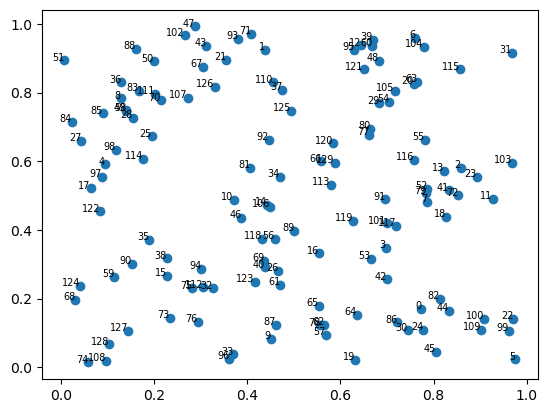

In [35]:
plt.scatter(x,y)
for i in range(N):
    plt.text(x[i], y[i], i, fontsize=7, ha='right')

for i in range(len(x) - 1):
    plt.plot([coordenadas_x[i], coordenadas_x[i + 1]], [coordenadas_y[i], coordenadas_y[i + 1]], color='blue')


plt.show()
